In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
#tf.compat.v1.enable_eager_execution()

from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import random

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from genesis.visualization import *
from genesis.generator import *
from genesis.predictor import *
from genesis.optimizer import *

from definitions.generator.mpradragonn_deconv_conv_generator_concat_trainmode import load_generator_network
from definitions.predictor.mpradragonn_deep_factorized_model import load_saved_predictor
#from definitions.predictor.mpradragonn_conv_model import load_saved_predictor

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import pearsonr

import seaborn as sns

from matplotlib import colors

from scipy.stats import norm

from genesis.vae import *

def set_seed(seed_value) :
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.set_random_seed(seed_value)

    # 5. Configure a new global `tensorflow` session
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)

def load_data(data_name, valid_set_size=0.05, test_set_size=0.05) :
    
    #Load cached dataframe
    cached_dict = pickle.load(open(data_name, 'rb'))
    x_train = cached_dict['x_train']
    y_train = cached_dict['y_train']
    x_test = cached_dict['x_test']
    y_test = cached_dict['y_test']

    g_nt = np.zeros((1, 1, 1, 4))
    g_nt[0, 0, 0, 2] = 1.

    x_train = np.concatenate([x_train, np.tile(g_nt, (x_train.shape[0], 1, 15, 1))], axis=2)
    x_test = np.concatenate([x_test, np.tile(g_nt, (x_test.shape[0], 1, 15, 1))], axis=2)
    
    return x_train, x_test

def load_predictor_model(model_path) :

    saved_model = Sequential()

    # sublayer 1
    saved_model.add(Conv1D(48, 3, padding='same', activation='relu', input_shape=(145, 4), name='dragonn_conv1d_1_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_1_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_1_copy'))

    saved_model.add(Conv1D(64, 3, padding='same', activation='relu', name='dragonn_conv1d_2_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_2_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_2_copy'))

    saved_model.add(Conv1D(100, 3, padding='same', activation='relu', name='dragonn_conv1d_3_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_3_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_3_copy'))

    saved_model.add(Conv1D(150, 7, padding='same', activation='relu', name='dragonn_conv1d_4_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_4_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_4_copy'))

    saved_model.add(Conv1D(300, 7, padding='same', activation='relu', name='dragonn_conv1d_5_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_5_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_5_copy'))

    saved_model.add(MaxPooling1D(3))

    # sublayer 2
    saved_model.add(Conv1D(200, 7, padding='same', activation='relu', name='dragonn_conv1d_6_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_6_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_6_copy'))

    saved_model.add(Conv1D(200, 3, padding='same', activation='relu', name='dragonn_conv1d_7_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_7_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_7_copy'))

    saved_model.add(Conv1D(200, 3, padding='same', activation='relu', name='dragonn_conv1d_8_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_8_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_8_copy'))

    saved_model.add(MaxPooling1D(4))

    # sublayer 3
    saved_model.add(Conv1D(200, 7, padding='same', activation='relu', name='dragonn_conv1d_9_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_9_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_9_copy'))

    saved_model.add(MaxPooling1D(4))

    saved_model.add(Flatten())
    saved_model.add(Dense(100, activation='relu', name='dragonn_dense_1_copy'))
    saved_model.add(BatchNormalization(name='dragonn_batchnorm_10_copy'))
    saved_model.add(Dropout(0.1, name='dragonn_dropout_10_copy'))
    saved_model.add(Dense(12, activation='linear', name='dragonn_dense_2_copy'))

    saved_model.compile(
        loss= "mean_squared_error",
        optimizer=keras.optimizers.SGD(lr=0.1)
    )

    saved_model.load_weights(model_path)
    
    return saved_model


Using TensorFlow backend.


In [2]:
#Specfiy problem-specific parameters

experiment_suffix = '_mpradragonn_medium_epoch_08_margin_neg_2_lower_fitness'

vae_model_prefix = "vae/saved_models/vae_mpradragonn_sv40_medium_low_kl_50_epochs"
vae_model_suffix = "_epoch_08"

#VAE model path
saved_vae_encoder_model_path = vae_model_prefix + "_encoder" + vae_model_suffix + ".h5"
saved_vae_decoder_model_path = vae_model_prefix + "_decoder" + vae_model_suffix + ".h5"

#Padding for the VAE
vae_upstream_padding = ''
vae_downstream_padding = 'G' * 15

#VAE sequence template
vae_sequence_template = 'N' * 145 + 'G' * 15

#VAE latent dim
vae_latent_dim = 100

#Oracle predictor model path
saved_predictor_model_path = '../../../seqprop/examples/mpradragonn/pretrained_deep_factorized_model.hdf5'

#Subtring indices for VAE
vae_pwm_start = 0
vae_pwm_end = 145

#VAE parameter collection
vae_params = [
    saved_vae_encoder_model_path,
    saved_vae_decoder_model_path,
    vae_upstream_padding,
    vae_downstream_padding,
    vae_latent_dim,
    vae_pwm_start,
    vae_pwm_end
]

#Load data set
vae_data_path = "vae/mpradragonn_sv40_cached_set_medium.pickle"

_, x_test = load_data(vae_data_path, valid_set_size=0.005, test_set_size=0.095)


mean log(likelihood) = -85.808857712259


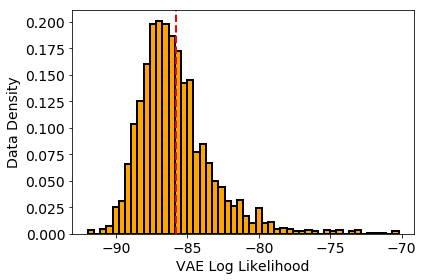

In [6]:
#Evaluate ELBO distribution on test set

#Load VAE models
vae_encoder_model = load_model(saved_vae_encoder_model_path, custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':min_pred, 'InstanceNormalization':InstanceNormalization})
vae_decoder_model = load_model(saved_vae_decoder_model_path, custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':min_pred, 'InstanceNormalization':InstanceNormalization})

#Compute multi-sample ELBO on test set
log_mean_p_vae_test, mean_log_p_vae_test, log_p_vae_test = evaluate_elbo(vae_encoder_model, vae_decoder_model, x_test, n_samples=128)

print("mean log(likelihood) = " + str(mean_log_p_vae_test))

#Log Likelihood Plot
plot_min_val = None
plot_max_val = None

f = plt.figure(figsize=(6, 4))

log_p_vae_test_hist, log_p_vae_test_edges = np.histogram(log_mean_p_vae_test, bins=50, density=True)
bin_width_test = log_p_vae_test_edges[1] - log_p_vae_test_edges[0]

plt.bar(log_p_vae_test_edges[1:] - bin_width_test/2., log_p_vae_test_hist, width=bin_width_test, linewidth=2, edgecolor='black', color='orange')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if plot_min_val is not None and plot_max_val is not None :
    plt.xlim(plot_min_val, plot_max_val)

plt.xlabel("VAE Log Likelihood", fontsize=14)
plt.ylabel("Data Density", fontsize=14)

plt.axvline(x=mean_log_p_vae_test, linewidth=2, color='red', linestyle="--")

plt.tight_layout()
plt.show()


mean log(likelihood) = -86.07382686816322


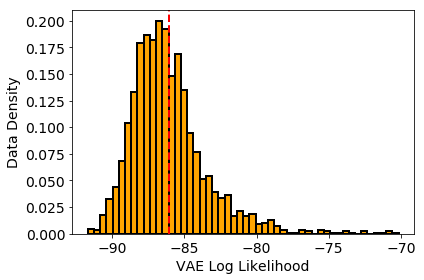

In [7]:
#Evaluate ELBO distribution on test set (training-level no. of samples)

#Load VAE models
vae_encoder_model = load_model(saved_vae_encoder_model_path, custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':min_pred, 'InstanceNormalization':InstanceNormalization})
vae_decoder_model = load_model(saved_vae_decoder_model_path, custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':min_pred, 'InstanceNormalization':InstanceNormalization})

#Compute multi-sample ELBO on test set
log_mean_p_vae_test, mean_log_p_vae_test, log_p_vae_test = evaluate_elbo(vae_encoder_model, vae_decoder_model, x_test, n_samples=32)

print("mean log(likelihood) = " + str(mean_log_p_vae_test))

#Log Likelihood Plot
plot_min_val = None
plot_max_val = None

f = plt.figure(figsize=(6, 4))

log_p_vae_test_hist, log_p_vae_test_edges = np.histogram(log_mean_p_vae_test, bins=50, density=True)
bin_width_test = log_p_vae_test_edges[1] - log_p_vae_test_edges[0]

plt.bar(log_p_vae_test_edges[1:] - bin_width_test/2., log_p_vae_test_hist, width=bin_width_test, linewidth=2, edgecolor='black', color='orange')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if plot_min_val is not None and plot_max_val is not None :
    plt.xlim(plot_min_val, plot_max_val)

plt.xlabel("VAE Log Likelihood", fontsize=14)
plt.ylabel("Data Density", fontsize=14)

plt.axvline(x=mean_log_p_vae_test, linewidth=2, color='red', linestyle="--")

plt.tight_layout()
plt.show()


In [3]:

#Define target isoform loss function
def get_isoform_loss(output_ix, fitness_target, fitness_weight=2., batch_size=32, n_samples=1, n_z_samples=1, mini_batch_size=1, seq_length=205, vae_loss_mode='bound', vae_divergence_weight=1., ref_vae_log_p=-10, vae_log_p_margin=1, decoded_pwm_epsilon=10**-6, pwm_start=0, pwm_end=70, pwm_target_bits=1.8, vae_pwm_start=0, entropy_weight=0.0, entropy_loss_mode='margin', similarity_weight=0.0, similarity_margin=0.5) :
    
    masked_entropy_mse = get_target_entropy_sme_masked(pwm_start=pwm_start, pwm_end=pwm_end, target_bits=pwm_target_bits)
    if entropy_loss_mode == 'margin' :
        masked_entropy_mse = get_margin_entropy_ame_masked(pwm_start=pwm_start, pwm_end=pwm_end, min_bits=pwm_target_bits)
    
    pwm_sample_entropy_func = get_pwm_margin_sample_entropy_masked(pwm_start=pwm_start, pwm_end=pwm_end, margin=similarity_margin, shift_1_nt=True)
    
    def loss_func(loss_tensors) :
        _, _, _, sequence_class, pwm_logits_1, pwm_logits_2, pwm_1, pwm_2, sampled_pwm_1, sampled_pwm_2, mask, sampled_mask, score_pred, vae_pwm_1, vae_sampled_pwm_1, z_mean_1, z_log_var_1, z_1, decoded_pwm_1 = loss_tensors
        
        #Specify costs
        fitness_loss = fitness_weight * K.mean(K.abs(score_pred[..., output_ix] - fitness_target), axis=1)
        
        #Construct VAE sequence inputs
        decoded_pwm_1 = K.clip(decoded_pwm_1, decoded_pwm_epsilon, 1. - decoded_pwm_epsilon)
        
        log_p_x_given_z_1 = K.sum(K.sum(vae_sampled_pwm_1[:, :, :, pwm_start-vae_pwm_start:pwm_end-vae_pwm_start, ...] * K.log(K.stop_gradient(decoded_pwm_1[:, :, :, pwm_start-vae_pwm_start:pwm_end-vae_pwm_start, ...])) / K.log(K.constant(10.)), axis=(-1, -2)), axis=-1)
        
        log_p_std_normal_1 = K.sum(normal_log_prob(z_1, 0., 1.) / K.log(K.constant(10.)), axis=-1)
        log_p_importance_1 = K.sum(normal_log_prob(z_1, z_mean_1, K.sqrt(K.exp(z_log_var_1))) / K.log(K.constant(10.)), axis=-1)
        
        log_p_vae_1 = log_p_x_given_z_1 + log_p_std_normal_1 - log_p_importance_1
        log_p_vae_div_n_1 = log_p_vae_1 - K.log(K.constant(n_z_samples, dtype='float32')) / K.log(K.constant(10.))

        #Calculate mean ELBO across samples (log-sum-exp trick)
        max_log_p_vae_1 = K.max(log_p_vae_div_n_1, axis=-1)

        log_mean_p_vae_1 = max_log_p_vae_1 + K.log(K.sum(10**(log_p_vae_div_n_1 - K.expand_dims(max_log_p_vae_1, axis=-1)), axis=-1)) / K.log(K.constant(10.))
        
        #Specify VAE divergence loss function
        vae_divergence_loss = 0.
        
        if vae_loss_mode == 'bound' :
            vae_divergence_loss = vae_divergence_weight * K.mean(K.switch(log_mean_p_vae_1 < ref_vae_log_p - vae_log_p_margin, -log_mean_p_vae_1 + (ref_vae_log_p - vae_log_p_margin), K.zeros_like(log_mean_p_vae_1)), axis=1)
        
        elif vae_loss_mode == 'penalty' :
            vae_divergence_loss = vae_divergence_weight * K.mean(-log_mean_p_vae_1, axis=1)
        
        elif vae_loss_mode == 'target' :
            vae_divergence_loss = vae_divergence_weight * K.mean((log_mean_p_vae_1 - (ref_vae_log_p - vae_log_p_margin))**2, axis=1)
        
        elif 'mini_batch_' in vae_loss_mode :
            mini_batch_log_mean_p_vae_1 = K.permute_dimensions(K.reshape(log_mean_p_vae_1, (int(batch_size / mini_batch_size), mini_batch_size, n_samples)), (0, 2, 1))
            mini_batch_mean_log_p_vae_1 = K.mean(mini_batch_log_mean_p_vae_1, axis=-1)
            tiled_mini_batch_mean_log_p_vae_1 = K.tile(mini_batch_mean_log_p_vae_1, (mini_batch_size, 1))
            
            if vae_loss_mode == 'mini_batch_bound' :
                vae_divergence_loss = vae_divergence_weight * K.mean(K.switch(tiled_mini_batch_mean_log_p_vae_1 < ref_vae_log_p - vae_log_p_margin, -tiled_mini_batch_mean_log_p_vae_1 + (ref_vae_log_p - vae_log_p_margin), K.zeros_like(tiled_mini_batch_mean_log_p_vae_1)), axis=1)
            elif vae_loss_mode == 'mini_batch_target' :
                vae_divergence_loss = vae_divergence_weight * K.mean((tiled_mini_batch_mean_log_p_vae_1 - (ref_vae_log_p - vae_log_p_margin))**2, axis=1)
        
        entropy_loss = entropy_weight * masked_entropy_mse(pwm_1, mask)
        entropy_loss += similarity_weight * K.mean(pwm_sample_entropy_func(sampled_pwm_1, sampled_pwm_2, sampled_mask), axis=1)
        
        #Compute total loss
        total_loss = fitness_loss + entropy_loss + vae_divergence_loss
        
        return total_loss
    
    return loss_func

class EpochVariableCallback(Callback):
    def __init__(self, my_variable, my_func):
        self.my_variable = my_variable       
        self.my_func = my_func
    def on_epoch_end(self, epoch, logs={}):
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))

#Function for running GENESIS
def run_genesis(sequence_templates, loss_func, model_path, batch_size=32, n_samples=1, n_z_samples=1, vae_params=None, n_epochs=10, steps_per_epoch=100) :
    
    #Build Generator Network
    _, generator = build_generator(batch_size, len(sequence_templates[0]), load_generator_network, n_classes=len(sequence_templates), n_samples=n_samples, sequence_templates=sequence_templates, batch_normalize_pwm=False)

    #Build Predictor Network and hook it on the generator PWM output tensor
    _, sample_predictor = build_predictor(generator, load_saved_predictor(model_path), batch_size, n_samples=n_samples, eval_mode='sample')

    #Build VAE model
    vae_tensors = []
    if vae_params is not None :
        encoder_model_path, decoder_model_path, vae_upstream_padding, vae_downstream_padding, vae_latent_dim, vae_pwm_start, vae_pwm_end = vae_params
        vae_tensors = build_vae(generator, encoder_model_path, decoder_model_path, batch_size=batch_size, seq_length=len(sequence_templates[0]), n_samples=n_samples, n_z_samples=n_z_samples, vae_latent_dim=vae_latent_dim, vae_upstream_padding=vae_upstream_padding, vae_downstream_padding=vae_downstream_padding, vae_pwm_start=vae_pwm_start, vae_pwm_end=vae_pwm_end)

    #Build Loss Model (In: Generator seed, Out: Loss function)
    _, loss_model = build_loss_model(sample_predictor, loss_func, extra_loss_tensors=vae_tensors)
    
    #Specify Optimizer to use
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

    #Compile Loss Model (Minimize self)
    loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

    #Fit Loss Model
    train_history = loss_model.fit(
        [], np.ones((1, 1)),
        epochs=n_epochs,
        steps_per_epoch=steps_per_epoch
    )

    return generator, sample_predictor, train_history


In [4]:
#Generate new random seed
print(np.random.randint(low=0, high=1000000))

3396


In [5]:
#Train APA Cleavage GENESIS Network

print("Training GENESIS")

#Number of PWMs to generate per objective
batch_size = 64
mini_batch_size = 8
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of VAE latent vector samples  at each grad step
n_z_samples = 32
#Number of epochs per objective to optimize
n_epochs = 50
#Number of steps (grad updates) per epoch
steps_per_epoch = 50

sequence_template = 'N' * 145

seed = 104590

K.clear_session()

set_seed(seed)

loss = get_isoform_loss(
    5,
    3.0,
    fitness_weight=0.1,
    batch_size=batch_size,
    n_samples=n_samples,
    n_z_samples=n_z_samples,
    mini_batch_size=mini_batch_size,
    seq_length=len(sequence_template),
    vae_loss_mode='mini_batch_bound',
    vae_divergence_weight=40.0 * 1./145.,
    ref_vae_log_p=-86.073,
    vae_log_p_margin=-2.0,
    pwm_start=vae_pwm_start + 0,
    pwm_end=vae_pwm_start + 0 + 145,
    vae_pwm_start=vae_pwm_start,
    pwm_target_bits=1.8,
    entropy_weight=0.5,
    entropy_loss_mode='margin',
    similarity_weight=5.0,
    similarity_margin=0.5
)

genesis_generator, genesis_predictor, train_history = run_genesis([sequence_template], loss, saved_predictor_model_path, batch_size, n_samples, n_z_samples, vae_params, n_epochs, steps_per_epoch)

genesis_generator.get_layer('lambda_rand_sequence_class').function = lambda inp: inp
genesis_generator.get_layer('lambda_rand_input_1').function = lambda inp: inp
genesis_generator.get_layer('lambda_rand_input_2').function = lambda inp: inp

genesis_predictor.get_layer('lambda_rand_sequence_class').function = lambda inp: inp
genesis_predictor.get_layer('lambda_rand_input_1').function = lambda inp: inp
genesis_predictor.get_layer('lambda_rand_input_2').function = lambda inp: inp

# Save model and weights
save_dir = 'saved_models'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)


model_name = 'genesis' + experiment_suffix + '_vae_kl_generator.h5'
model_path = os.path.join(save_dir, model_name)
genesis_generator.save(model_path)
print('Saved trained model at %s ' % model_path)

model_name = 'genesis' + experiment_suffix + '_vae_kl_predictor.h5'
model_path = os.path.join(save_dir, model_name)
genesis_predictor.save(model_path)
print('Saved trained model at %s ' % model_path)


Training GENESIS
False
Epoch 1/50
50/50 [==============================] - 13s 256ms/step - loss: 2.7225
Epoch 2/50
50/50 [==============================] - 5s 99ms/step - loss: 1.8258
Epoch 3/50
50/50 [==============================] - 5s 99ms/step - loss: 2.3298
Epoch 4/50
50/50 [==============================] - 5s 99ms/step - loss: 2.0888
Epoch 5/50
50/50 [==============================] - 5s 99ms/step - loss: 1.9369
Epoch 6/50
50/50 [==============================] - 5s 100ms/step - loss: 1.6613
Epoch 7/50
50/50 [==============================] - 5s 99ms/step - loss: 1.6017
Epoch 8/50
50/50 [==============================] - 5s 98ms/step - loss: 1.9575
Epoch 9/50
50/50 [==============================] - 5s 97ms/step - loss: 1.5704
Epoch 10/50
50/50 [==============================] - 5s 97ms/step - loss: 1.3101
Epoch 11/50
50/50 [==============================] - 5s 96ms/step - loss: 1.0488
Epoch 12/50
50/50 [==============================] - 5s 98ms/step - loss: 0.8959
Epoch 13/50

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


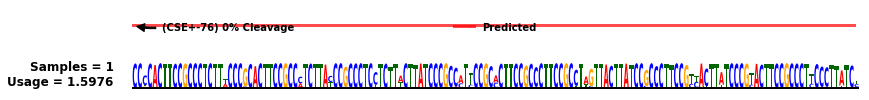

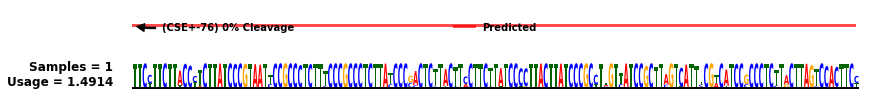

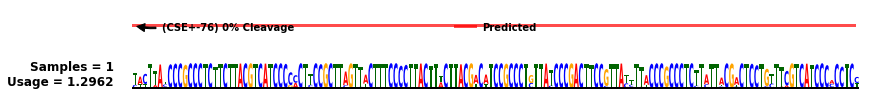

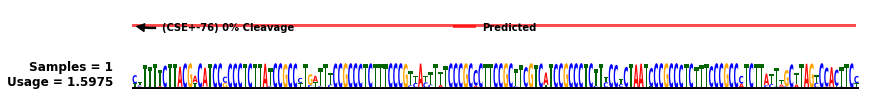

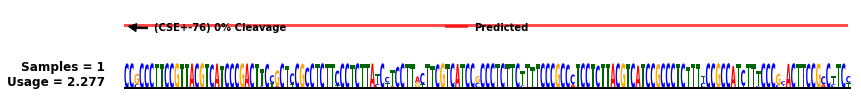

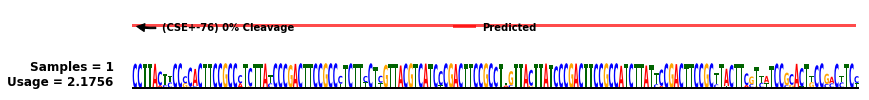

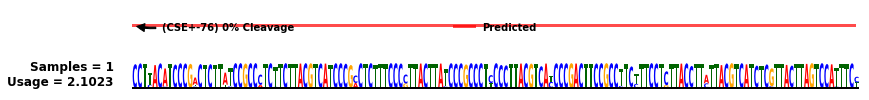

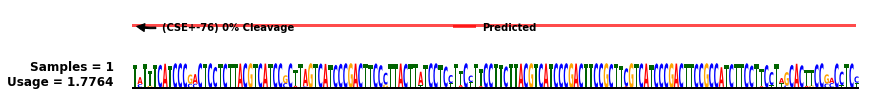

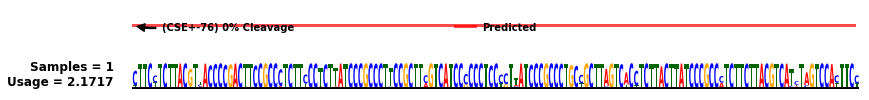

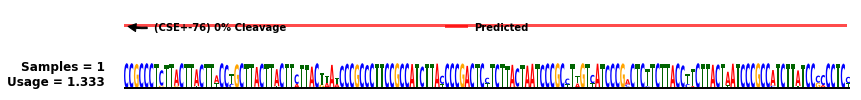

In [5]:
#Load GENESIS models and predict sample sequences

batch_size = 64

model_names = [
    'genesis' + experiment_suffix + '_vae_kl',
]

sequence_template = 'N' * 145

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = model_names[0] + '_predictor.h5'
model_path = os.path.join(save_dir, model_name)

predictor = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})

n = batch_size

sequence_class = np.array([0] * n).reshape(-1, 1) #np.random.uniform(-6, 6, (n, 1)) #

noise_1 = np.random.uniform(-1, 1, (n, 100))
noise_2 = np.random.uniform(-1, 1, (n, 100))

pred_outputs = predictor.predict([sequence_class, noise_1, noise_2], batch_size=batch_size)

_, _, _, optimized_pwm, _, _, _, _, _, score_pred = pred_outputs

#Plot one PWM sequence logo per optimized objective (Experiment 'Punish A-runs')

for pwm_index in range(10) :

    pwm = np.expand_dims(optimized_pwm[pwm_index, :, :, 0], axis=0)
    cut = np.zeros((1, 145))
    score = np.expand_dims(np.expand_dims(score_pred[pwm_index, 0, 5], axis=-1), axis=0)

    plot_seqprop_logo(pwm, score, cut, annotate_peaks='max', sequence_template=sequence_template, figsize=(12, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=0, plot_end=145, save_figs=True, fig_name='genesis' + experiment_suffix + "_pwm_index_" + str(pwm_index), fig_dpi=150)


In [6]:
#Load models

#Load VAE models
vae_encoder_model = load_model(saved_vae_encoder_model_path, custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':min_pred, 'InstanceNormalization':InstanceNormalization})
vae_decoder_model = load_model(saved_vae_decoder_model_path, custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':min_pred, 'InstanceNormalization':InstanceNormalization})

predictor_model = load_predictor_model(saved_predictor_model_path)

den_name = 'genesis' + experiment_suffix + '_vae_kl'
den_model = load_model("saved_models/" + den_name + "_predictor.h5", custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [7]:
#Setup predictor function

predictor_upstream_padding = ""
predictor_downstream_padding = ""
predictor_pwm_start = 0
predictor_pwm_end = 145

predictor_upstream_padding_one_hots = None
if len(predictor_upstream_padding) > 0 :
    predictor_upstream_padding_one_hots = one_hot_encode(predictor_upstream_padding, n=1, singleton_axis=1)

predictor_downstream_padding_one_hots = None
if len(predictor_downstream_padding) > 0 :
    predictor_downstream_padding_one_hots = one_hot_encode(predictor_downstream_padding, n=1, singleton_axis=1)

#Predict fitness score
def _predict_func(sequence_one_hots, predictor_model) :
    x_1 = sequence_one_hots[:, 0, predictor_pwm_start:predictor_pwm_end, :]
    
    if len(predictor_upstream_padding) > 0 :
        x_1 = np.concatenate([np.tile(predictor_upstream_padding_one_hots[:, 0, :, :], (x_1.shape[0], 1, 1)), x_1], axis=1)
    
    if len(predictor_downstream_padding) > 0 :
        x_1 = np.concatenate([x_1, np.tile(predictor_downstream_padding_one_hots[:, 0, :, :], (x_1.shape[0], 1, 1))], axis=1)
    
    score_pred = predictor_model.predict(x=[x_1], batch_size=32, verbose=False)
    
    return score_pred[:, 5]


In [8]:
#Evaluate ELBOs
n_z_samples = 128
n = 1984

#Evaluate VAE Likelihood on test data

log_mean_p_vae_test, mean_log_p_vae_test, _ = evaluate_elbo(vae_encoder_model, vae_decoder_model, x_test[:n], n_samples=n_z_samples)
fitness_score_test = _predict_func(x_test, predictor_model)


#Evaluate VAE Likelihood on generated data

sequence_class = np.array([0] * n).reshape(-1, 1) #np.random.uniform(-6, 6, (n, 1)) #

noise_1 = np.random.uniform(-1, 1, (n, 100))
noise_2 = np.random.uniform(-1, 1, (n, 100))

sampled_sequences_new = den_model.predict([sequence_class, noise_1, noise_2], batch_size=batch_size, verbose=False)[5]
sampled_sequences_new = np.moveaxis(sampled_sequences_new[:, 0, ...], 3, 1)

x_new = np.concatenate([
    one_hot_encode(vae_upstream_padding, n=n, singleton_axis=1),
    sampled_sequences_new[:, :, vae_pwm_start:vae_pwm_end, :],
    one_hot_encode(vae_downstream_padding, n=n, singleton_axis=1)
], axis=2)

log_mean_p_vae_new, mean_log_p_vae_new, _ = evaluate_elbo(vae_encoder_model, vae_decoder_model, x_new, n_samples=n_z_samples)
fitness_score_new = _predict_func(x_new, predictor_model)


#Evaluate VAE Likelihood on random data

x_random = np.zeros((n, 1, 160, 4))
for i in range(n) :
    random_seq = ''
    for j in range(len(vae_sequence_template)) :
        if vae_sequence_template[j] == 'N' :
            rand_letter = np.random.choice(['A', 'C', 'G', 'T'], replace=False)
            random_seq += rand_letter
        else :
            random_seq += vae_sequence_template[j]
    
    for j in range(len(random_seq)) :
        if random_seq[j] == 'A' :
            x_random[i, 0, j, 0] = 1.
        elif random_seq[j] == 'C' :
            x_random[i, 0, j, 1] = 1.
        elif random_seq[j] == 'G' :
            x_random[i, 0, j, 2] = 1.
        elif random_seq[j] == 'T' :
            x_random[i, 0, j, 3] = 1.

log_mean_p_vae_random, mean_log_p_vae_random, _ = evaluate_elbo(vae_encoder_model, vae_decoder_model, x_random, n_samples=n_z_samples)
fitness_score_random = _predict_func(x_random, predictor_model)


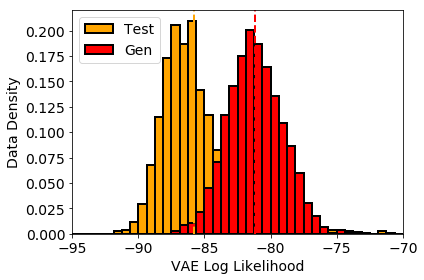

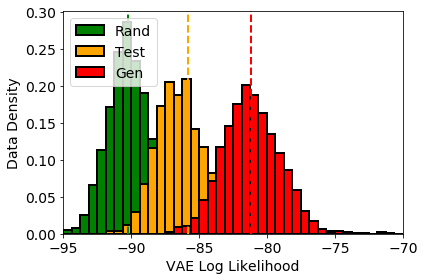

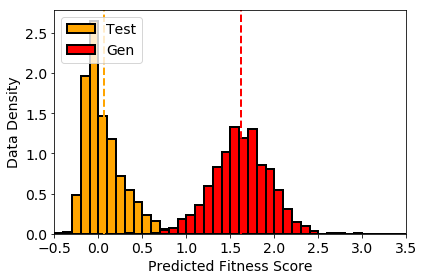

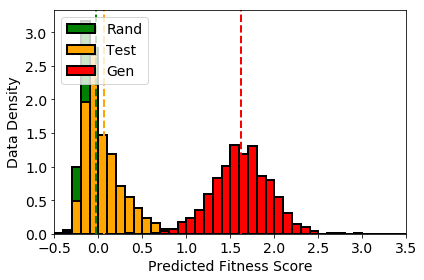

In [9]:
#Compare VAE Log Likelihoods (ELBO), Without random background

plot_joint_histo(
    [log_mean_p_vae_test, log_mean_p_vae_new],
    ['Test', 'Gen'],
    ['orange', 'red'],
    'VAE Log Likelihood',
    'Data Density',
    min_val=-95,
    max_val=-70,
    n_bins=40,
    figsize=(6, 4),
    save_fig=True,
    fig_name="mpradragonn_sv40_" + experiment_suffix + "_likelihood"
)

#Compare VAE Log Likelihoods (ELBO), With random background

plot_joint_histo(
    [log_mean_p_vae_random, log_mean_p_vae_test, log_mean_p_vae_new],
    ['Rand', 'Test', 'Gen'],
    ['green', 'orange', 'red'],
    'VAE Log Likelihood',
    'Data Density',
    min_val=-95,
    max_val=-70,
    n_bins=40,
    figsize=(6, 4),
    save_fig=True,
    fig_name="mpradragonn_sv40_" + experiment_suffix + "_likelihood_w_random"
)

#Compare Fitness Scores, Without random background

plot_joint_histo(
    [fitness_score_test, fitness_score_new],
    ['Test', 'Gen'],
    ['orange', 'red'],
    'Predicted Fitness Score',
    'Data Density',
    min_val=-0.5,
    max_val=3.5,
    n_bins=40,
    figsize=(6, 4),
    save_fig=True,
    fig_name="mpradragonn_sv40_" + experiment_suffix + "_fitness"
)

#Compare Fitness Scores, With random background

plot_joint_histo(
    [fitness_score_random, fitness_score_test, fitness_score_new],
    ['Rand', 'Test', 'Gen'],
    ['green', 'orange', 'red'],
    'Predicted Fitness Score',
    'Data Density',
    min_val=-0.5,
    max_val=3.5,
    n_bins=40,
    figsize=(6, 4),
    save_fig=True,
    fig_name="mpradragonn_sv40_" + experiment_suffix + "_fitness_w_random"
)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(256, 145)


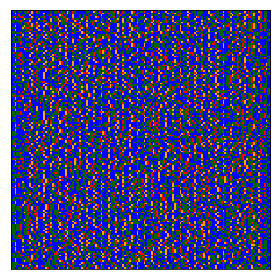

In [5]:

save_figs = False

#Load GENESIS models and predict sample sequences

batch_size = 64

model_names = [
    'genesis' + experiment_suffix + '_vae_kl',
]

sequence_template = 'N' * 145

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = model_names[0] + '_predictor.h5'
model_path = os.path.join(save_dir, model_name)

predictor = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})

n = batch_size * 4

sequence_class = np.array([0] * n).reshape(-1, 1) #np.random.uniform(-6, 6, (n, 1)) #

noise_1 = np.random.uniform(-1, 1, (n, 100))
noise_2 = np.random.uniform(-1, 1, (n, 100))

pred_outputs = predictor.predict([sequence_class, noise_1, noise_2], batch_size=batch_size)

_, _, _, optimized_pwm, _, _, _, _, _, score_pred = pred_outputs

pwms = optimized_pwm[:, :, :, 0]

flat_pwms = np.zeros((n, 145))
for i in range(n) :
    for j in range(145) :
        max_nt_ix = np.argmax(pwms[i, j, :])

        flat_pwms[i, j] = max_nt_ix + 1


#flat_pwms = flat_pwms[:, 70-45: 76+45]

print(flat_pwms.shape)



cmap = colors.ListedColormap(['red', 'blue', 'orange', 'darkgreen'])
#cmap = colors.ListedColormap([cmap_colors(0.0), cmap_colors(0.1), cmap_colors(0.2), cmap_colors(0.3)])
bounds=[0, 1, 2, 3, 4, 5]
norm = colors.BoundaryNorm(bounds, cmap.N)


f = plt.figure(figsize=(4, 12))

plt.imshow(flat_pwms[:145, :], aspect='equal', interpolation='nearest', origin='lower', cmap=cmap, norm=norm)

plt.xticks([], [])
plt.yticks([], [])

plt.tight_layout()

if save_figs :
    plt.savefig("mpradragonn_sv40_" + experiment_suffix + '_diversity_seqs.png', transparent=True, dpi=150)
    plt.savefig("mpradragonn_sv40_" + experiment_suffix + '_diversity_seqs.svg')
    plt.savefig("mpradragonn_sv40_" + experiment_suffix + '_diversity_seqs.eps')

plt.show()


N Sequences = 10
64/64 [==============================] - 0s 550us/step
Number of unique sequences = 10
Duplication rate = 0.0
N Sequences = 100
128/128 [==============================] - 0s 556us/step
Number of unique sequences = 100
Duplication rate = 0.0
N Sequences = 1000
1024/1024 [==============================] - 1s 558us/step
Number of unique sequences = 1000
Duplication rate = 0.0
N Sequences = 10000
10048/10048 [==============================] - 6s 549us/step
Number of unique sequences = 10000
Duplication rate = 0.0


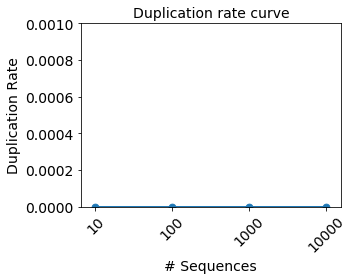

In [6]:
#Estimate duplication rates

def get_consensus_sequence(pwm) :
    consensus = ''
    
    for j in range(pwm.shape[0]) :
        nt_ix = np.argmax(pwm[j, :])
        
        if nt_ix == 0 :
            consensus += 'A'
        elif nt_ix == 1 :
            consensus += 'C'
        elif nt_ix == 2 :
            consensus += 'G'
        elif nt_ix == 3 :
            consensus += 'T'
    
    return consensus

f = plt.figure(figsize=(5, 4))

n_sequences_large_list = [10, 100, 1000, 10000]

ls = []

save_figs = False

dup_rates = []

k = i

max_dup_rate = 0.

for n_sequences_large in n_sequences_large_list :
    n_sequences_ceil_large = int(n_sequences_large / 64) * 64 + 64

    print("N Sequences = " + str(n_sequences_large))

    sequence_class = np.tile(np.array([[0]]), (n_sequences_ceil_large, 1))

    noise_1 = np.random.uniform(-1, 1, (n_sequences_ceil_large, 100))
    noise_2 = np.random.uniform(-1, 1, (n_sequences_ceil_large, 100))

    pred_outputs = predictor.predict([sequence_class, noise_1, noise_2], batch_size=64, verbose=True)

    _, _, _, optimized_pwm_large, _, sampled_pwm_large, _, _, _, _ = pred_outputs

    onehots_large = sampled_pwm_large[:, 0, :, :, :]


    consensus_seqs_large = []

    for ii in range(onehots_large.shape[0]) :
        consensus_seqs_large.append(get_consensus_sequence(onehots_large[ii, :, :, 0]))

    consensus_seqs_large = np.array(consensus_seqs_large, dtype=np.object)

    #Sample first n_sequences
    onehots_large_kept = onehots_large[:n_sequences_large, :, :]
    consensus_large_seqs_kept = consensus_seqs_large[:n_sequences_large]

    n_unique_seqs_kept = len(np.unique(consensus_large_seqs_kept))

    print("Number of unique sequences = " + str(n_unique_seqs_kept))

    dup_rate = 1. - n_unique_seqs_kept / n_sequences_large
    dup_rates.append(dup_rate)

    print("Duplication rate = " + str(round(dup_rate, 4)))


l1 = plt.plot(np.arange(len(n_sequences_large_list)), dup_rates, linewidth=3, linestyle='-')
plt.scatter(np.arange(len(n_sequences_large_list)), dup_rates, s=45)

ls.append(l1[0])

max_dup_rate = max(max_dup_rate, np.max(dup_rates))

plt.xlabel("# Sequences", fontsize=14)
plt.ylabel("Duplication Rate", fontsize=14)
plt.xticks(np.arange(len(n_sequences_large_list)), n_sequences_large_list, fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.ylim(0, max_dup_rate * 1.10 + 0.001)

plt.title("Duplication rate curve", fontsize=14)

plt.tight_layout()

if save_figs :
    plt.savefig("mpradragonn_sv40_" + experiment_suffix + "_dup_rate_curve.eps")
    plt.savefig("mpradragonn_sv40_" + experiment_suffix + "_dup_rate_curve.svg")
    plt.savefig("mpradragonn_sv40_" + experiment_suffix + "_dup_rate_curve.png", transparent=True, dpi=150)

plt.show()
